In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from matplotlib import cm
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from joblib import dump, load

### GET THE DATA

In [3]:
walkDF = pd.read_csv("data/readyToTrain/Walking")
walkDF['activity'] = 1

runDF = pd.read_csv("data/readyToTrain/Running")
runDF['activity'] = 2

standDF = pd.read_csv("data/readyToTrain/Standing")
standDF['activity'] = 0

# Merge all data into 1 dataframe
dataDF  = pd.concat([standDF, walkDF, runDF]).reset_index(drop=True).loc[:, 'mean1AccX': 'activity']

X = dataDF.loc[:,'mean1AccX':'max1Acc-turns']
y = dataDF.activity

# DATA OUTPUT
### 1. Model Scores
### 2. Classification Report
### 3. ROC Curve for multiple classes

In [4]:
OUTPUT_TEMPLATE = (
    'Classifier :  {name}\n'
    'Train Score:  {train_score:.3f}\n'
    'Valid Score:  {valid_score:.3f}\n'
)


# 0: name,
# 1: model.score(X_train, y_train), 
# 2: model.score(X_valid, y_valid), 
# 3: y_valid, 
# 4: model.predict(X_valid), 
# 5: model.predict_proba(X_valid)
    
def outData(results):
    print(OUTPUT_TEMPLATE.format(
        name=results[0],
        train_score=results[1],
        valid_score=results[2],
        ))  

    print("Classification Report:")
    print(classification_report(results[3], results[4]))
    print("")
    roc_analysis(results[3], results[4], results[5])
    

# Code adapted from https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
def roc_analysis(y_valid, pred, pred_prob):
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 3

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_valid, pred_prob[:,i], pos_label=i)

    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='-',color='orange', label='Standing')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='purple', label='Walking')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Running')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
#     plt.savefig('Multiclass ROC',dpi=300)
    plt.show()


def plot_cv(k, k_fold):
    # Average score comparison
    mean_k = pd.DataFrame(k_fold[['svc', 'boosting', 'Random_forest', 'k_nearest_neighbours', 'naive_bayes', 'neural_network', 'decision_tree']].mean())
    mean_k['classifier'] = mean_k.index
    mean_k = mean_k.reset_index(drop=True)
    mean_k.rename(columns={0: 'scores'}, inplace=True)
    mean_k['scores'] = mean_k.scores
    
    mean_k.plot(kind='bar', x='classifier', y='scores')
    plt.title(f'Mean Scores After Cross Validation: {k}-Fold')
    plt.xlabel('Classifier')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()

    # Individual Classifier Results
    k_fold['index'] = k_fold.index
    k_fold = k_fold.reset_index(drop=True)
    
    # Individual Scores
    ax = plt.gca()
    k_fold.plot(kind='bar', x='index', y='svc', color='green', ax=ax)
    plt.title('SVC Scores After Cross Validation')
    plt.xlabel('Dataset')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()
    
    ax = plt.gca()
    k_fold.plot(kind='bar', x='index', y='boosting', color='red', ax=ax)
    plt.title('Gradient Boosting Scores After Cross Validation')
    plt.xlabel('Dataset')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()
    
    ax = plt.gca()
    k_fold.plot(kind='bar', x='index', y='Random_forest', color='blue', ax=ax)
    plt.title('Random Forest Scores After Cross Validation')
    plt.xlabel('Dataset')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()
    
    ax = plt.gca()
    k_fold.plot(kind='bar', x='index', y='k_nearest_neighbours', color='black', ax=ax)
    plt.title('KNeigbors Scores After Cross Validation')
    plt.xlabel('Dataset')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()
    
    ax = plt.gca()
    k_fold.plot(kind='bar', x='index', y='naive_bayes', ax=ax)
    plt.title('Naive Bayes Scores After Cross Validation')
    plt.xlabel('Dataset')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()
    
    ax = plt.gca()
    k_fold.plot(kind='bar', x='index', y='neural_network', color='purple', ax=ax)
    plt.title('Neural Network Scores After Cross Validation')
    plt.xlabel('Dataset')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()
    
    ax = plt.gca()
    k_fold.plot(kind='bar', x='index', y='decision_tree', color='pink', ax=ax)
    plt.title('Decision Tree Scores After Cross Validation')
    plt.xlabel('Dataset')
    plt.ylabel('Score: 0.0 - 1.0')
    plt.show()

# Classifiers
### 1. Random Forest
### 2. KNeighbors
### 3. Naive Bayes (Gaussian)
### 4. Neural Nets (MLPClassifier)
### 5. Gradient Boosting
### 6. SVC
### 7. Decision Tree 
### 8. PCA (not used)

In [5]:
def random_forest(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            RandomForestClassifier(n_estimators=93, max_depth=5,min_samples_leaf=2)
        ).fit(X_train, y_train)
    
    dump(model, 'models/random_forest.joblib')
    
    outData(["Random Forest", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])
    
    

In [6]:
def kn_neighbors(X, y):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            MinMaxScaler(),
            KNeighborsClassifier(n_neighbors=3)
        ).fit(X_train, y_train)
    
    dump(model, 'models/kn_neighbors.joblib')
    
    outData(["KNeighbors", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])

In [7]:
def naive_bayes(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            StandardScaler(),
            GaussianNB()
        ).fit(X_train, y_train) 
    
    dump(model, 'models/naive_bayes.joblib')
    
    outData(["Naive Bayes", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])

In [8]:
def neural_nets(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            MLPClassifier(solver='lbfgs', hidden_layer_sizes=())
        ).fit(X_train, y_train)
    
    dump(model, 'models/neural_network.joblib')
    
    outData(["MLP (Neural Network)", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])

In [9]:
def gradient_boosting(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_leaf=0.3)
        ).fit(X_train, y_train)
    
    dump(model, 'models/gradient_boosting.joblib')
    
    outData(["gradient_boosting", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])

In [10]:
def svc_classifier(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            SVC(kernel='linear', C=2.0, probability=True)
        ).fit(X_train, y_train)
    
    dump(model, 'models/svc_classifier.joblib')
    
    outData(["SVC", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])

In [11]:
def decision_tree(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            DecisionTreeClassifier(max_depth=15, min_samples_leaf=4)
        ).fit(X_train, y_train)
    
    dump(model, 'models/decision_tree.joblib')
    
    outData(["Decision Tree", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])

In [12]:
def pca(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = make_pipeline(
            StandardScaler(),
            PCA(2),
            SVC(kernel='linear', C=2.0)
        ).fit(X_train, y_train)
    
    outData(["PCA", model.score(X_train, y_train), model.score(X_valid, y_valid), y_valid, model.predict(X_valid), model.predict_proba(X_valid)])

# K-folds Cross Validation

In [13]:
def get_score(model,X_train, X_valid, y_train, y_valid):
    model.fit(X_train, y_train)
    return model.score(X_valid, y_valid)


def k_folds_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,y)

    a = np.array(X)
    b = np.array(y)
    
    
    
    folds = StratifiedKFold(n_splits=10)
    
    scores_svc = []
    scores_boosting=[]
    scores_random_forest=[]
    scores_k_neighbour=[]
    scores_naives_bayes=[]
    scores_neural_nets=[]
    scores_decision_tree = []


    for train_index, valid_index in folds.split(X,y):
        X_train, X_valid, y_train, y_valid = a[train_index],a[valid_index], \
                                           b[train_index],b[valid_index]

        scores_svc.append(get_score(SVC(kernel='linear', C=2.0, probability=True), X_train, X_valid, y_train, y_valid))
        scores_boosting.append(get_score(GradientBoostingClassifier(n_estimators=90, max_depth=10, min_samples_leaf=0.1), X_train, X_valid, y_train, y_valid))
        scores_random_forest.append(get_score(RandomForestClassifier(n_estimators=93, max_depth=5), X_train, X_valid, y_train, y_valid))
        scores_k_neighbour.append(get_score((KNeighborsClassifier(n_neighbors=3)), X_train, X_valid, y_train, y_valid))
        scores_naives_bayes.append(get_score(GaussianNB(), X_train, X_valid, y_train, y_valid))
        scores_neural_nets.append(get_score(MLPClassifier(solver='lbfgs', hidden_layer_sizes=()), X_train, X_valid, y_train, y_valid))
        scores_decision_tree.append(get_score(DecisionTreeClassifier(max_depth=15, min_samples_leaf=4), X_train, X_valid, y_train, y_valid))
        
    df1=pd.DataFrame(scores_svc,columns=['svc'])
    df2=pd.DataFrame(scores_boosting,columns=['boosting'])
    df3=pd.DataFrame(scores_random_forest,columns=['Random_forest'])
    df4=pd.DataFrame(scores_k_neighbour,columns=['k_nearest_neighbours'])
    df5=pd.DataFrame(scores_naives_bayes,columns=['naive_bayes'])
    df6=pd.DataFrame(scores_neural_nets,columns=['neural_network'])
    df7=pd.DataFrame(scores_decision_tree,columns=['decision_tree'])
    
    k=[df1,df2,df3,df4,df5,df6,df7]
    k_fold=pd.concat(k,axis=1)

    plot_cv(folds, k_fold)

#### 10-Fold Cross Validation Results

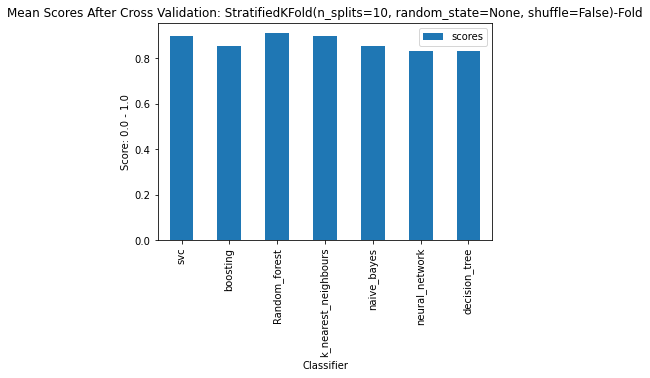

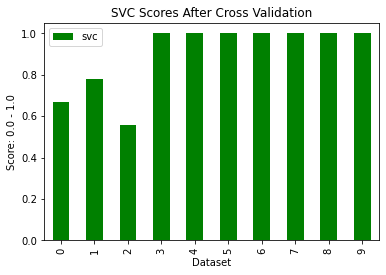

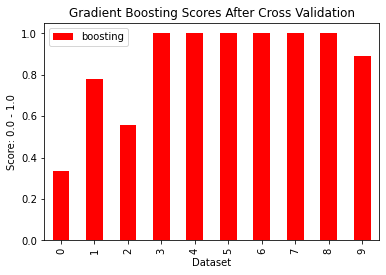

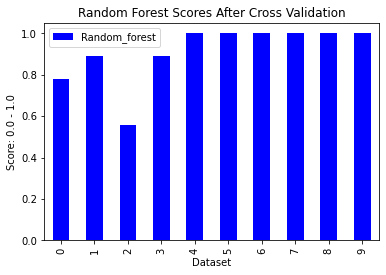

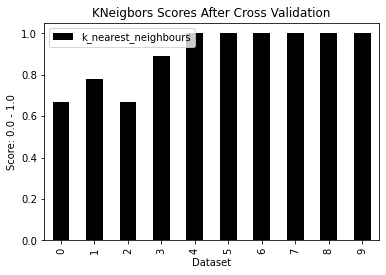

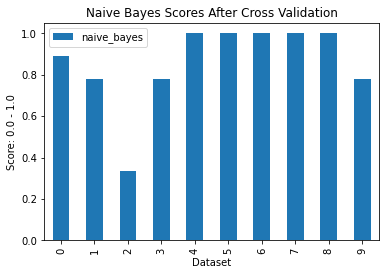

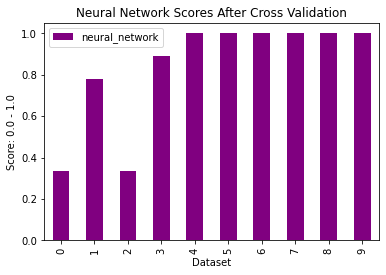

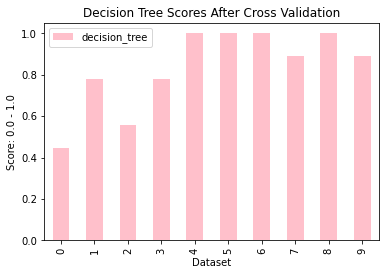

In [14]:
k_folds_cv(X, y)

# Modeling and Training the data

### Random Forest

Classifier :  Random Forest
Train Score:  1.000
Valid Score:  0.957

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.90      1.00      0.95         9
           2       1.00      0.86      0.92         7

    accuracy                           0.96        23
   macro avg       0.97      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23




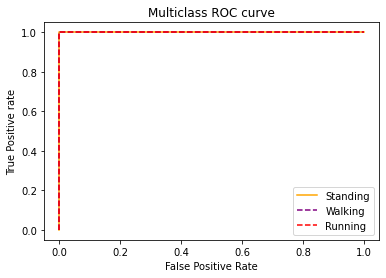

In [15]:
np.random.seed(1212)
random_forest(X, y)

### KNeighbors

Classifier :  KNeighbors
Train Score:  0.940
Valid Score:  0.870

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.80      0.89      0.84         9
           2       1.00      0.71      0.83         7

    accuracy                           0.87        23
   macro avg       0.89      0.87      0.87        23
weighted avg       0.88      0.87      0.87        23




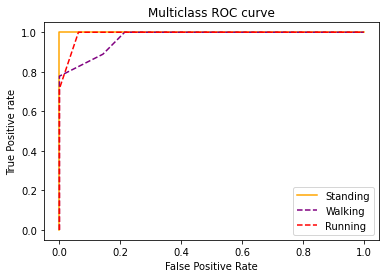

In [16]:
np.random.seed(1212)
kn_neighbors(X, y)

### Gradient Boosting

Classifier :  gradient_boosting
Train Score:  1.000
Valid Score:  0.913

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.82      1.00      0.90         9
           2       1.00      0.71      0.83         7

    accuracy                           0.91        23
   macro avg       0.94      0.90      0.91        23
weighted avg       0.93      0.91      0.91        23




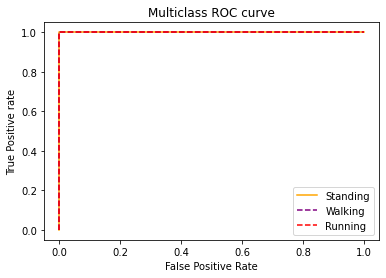

In [17]:
np.random.seed(1212)
gradient_boosting(X, y)

### SVC Classifier

Classifier :  SVC
Train Score:  0.970
Valid Score:  0.957

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.90      1.00      0.95         9
           2       1.00      0.86      0.92         7

    accuracy                           0.96        23
   macro avg       0.97      0.95      0.96        23
weighted avg       0.96      0.96      0.96        23




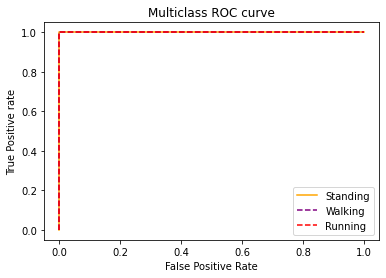

In [18]:
np.random.seed(1212)
svc_classifier(X, y)

### Neural Network

Classifier :  MLP (Neural Network)
Train Score:  1.000
Valid Score:  0.913

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.82      1.00      0.90         9
           2       1.00      0.71      0.83         7

    accuracy                           0.91        23
   macro avg       0.94      0.90      0.91        23
weighted avg       0.93      0.91      0.91        23




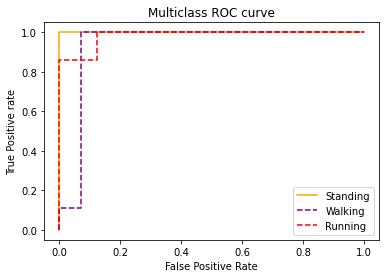

In [19]:
np.random.seed(1212)
neural_nets(X, y)

### Naive Bayes

Classifier :  Naive Bayes
Train Score:  0.955
Valid Score:  0.783

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.78      0.78      0.78         9
           2       0.57      1.00      0.73         4

    accuracy                           0.78        23
   macro avg       0.78      0.83      0.78        23
weighted avg       0.84      0.78      0.79        23




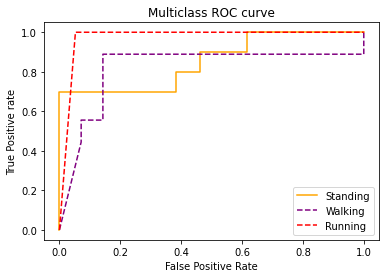

In [20]:
np.random.seed(12121)
naive_bayes(X, y)

### Decision Tree

Classifier :  Decision Tree
Train Score:  0.940
Valid Score:  0.870

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.78      0.88         9
           2       0.86      0.86      0.86         7

    accuracy                           0.87        23
   macro avg       0.88      0.88      0.87        23
weighted avg       0.89      0.87      0.87        23




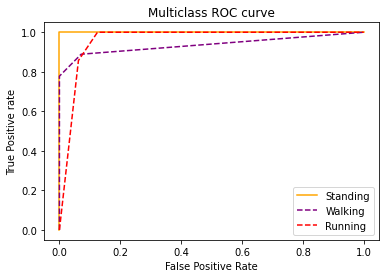

In [21]:
np.random.seed(1212)
decision_tree(X, y)